### Build a DNN for ECG Signal Classification (5 classes)  - Pytorch
This is the implementation of an MLP for classifying the ECG signals. <br>
Your task is to design new DNNs for ECG signal classification <br>
You can use this file as a template

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import torch.optim as optim

## The Neural Network: MLP  (Replace this with your MLP/CNN and rename the file)

In [ ]:
"""
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=187, out_features=256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, 5)
    def forward(self, x):
        x=nnF.relu(self.linear1(x))
        x=nnF.relu(self.linear2(x))
        z=self.linear3(x)
        #y=nnF.softmax(z, dim=1)
        return z
"""
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Linear layers
        self.linear1 = nn.Linear(187, 256)  # Input -> Layer 1
        self.linear2 = nn.Linear(256, 128)  # Layer 1 -> Layer 2
        self.linear3 = nn.Linear(128, 64)   # Layer 2 -> Layer 3
        self.norm3 = nn.LayerNorm(128)      # Normalization after Layer 2

        self.linear4 = nn.Linear(64, 32)    # Layer 3 -> Layer 4
        self.norm4 = nn.LayerNorm(64)       # Normalization after Layer 3

        self.linear5 = nn.Linear(32, 16)    # Layer 4 -> Layer 5
        self.norm5 = nn.LayerNorm(32)       # Normalization after Layer 4

        self.linear6 = nn.Linear(16, 5)     # Layer 5 -> Output

        # Pooling layers
        self.avg1 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.avg2 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.avg3 = nn.AvgPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        # Layer 1
        x1 = nnF.relu(self.linear1(x))  # Apply ReLU activation
        x1a = self.avg1(x1.unsqueeze(1)).squeeze(1)  # Pooling after Layer 1

        # Layer 2
        x2 = nnF.relu(self.linear2(x1)) + x1a  # Residual connection with pooled output
        x2a = self.avg2(x2.unsqueeze(1)).squeeze(1)  # Pooling after Layer 2

        # Layer 3
        x3 = nnF.relu(self.linear3(self.norm3(x2))) + x2a  # Residual connection with pooled output

        # Layer 4
        x3a = self.avg3(x3.unsqueeze(1)).squeeze(1)  # Pool twice to downsample to 16
        x4 = nnF.relu(self.linear4(self.norm4(x3))) + x3a  # Residual connection

        # Layer 5
        x5 = nnF.relu(self.linear5(self.norm5(x4)))  # No residual connection here

        # Output layer
        z = self.linear6(x5)  # Final output

        return z



In [ ]:
#debug your network here
#make sure it works
model=Net()
x=torch.rand(10,187)
#x=torch.rand(10,1,187) if network is CNN
z=model(x)
print(z.shape)

torch.Size([10, 5])


In [ ]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

In [ ]:
def cal_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the standard classification accuracy
    M=confusion.copy().astype('float32')
    acc = M.diagonal().sum()/M.sum()
    sens=np.zeros(M.shape[0])
    prec=np.zeros(M.shape[0])
    for n in range(0, M.shape[0]):
        TP=M[n,n]
        FN=np.sum(M[n,:])-TP
        FP=np.sum(M[:,n])-TP
        sens[n]=TP/(TP+FN)
        prec[n]=TP/(TP+FP)
    return acc, sens, prec

## The function to train the model

In [ ]:
def train(model, device, optimizer, dataloader, epoch):
    model.train()#set model to training mode
    loss_train=0
    acc_train =0
    sample_count=0
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear grad of each parameter
        Z = model(X)#forward pass
        loss = nnF.cross_entropy(Z, Y)
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()
        #do not need softmax
        Yp = Z.data.max(dim=1)[1]  # get the index of the max
        acc_train+= torch.sum(Yp==Y).item()
        sample_count+=X.size(0)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    #due to upsampling, len(dataloader.dataset) != sample_count
    #acc_train/=len(dataloader.dataset)
    acc_train/=sample_count
    return loss_train, acc_train

## The Function to test the model

In [ ]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    acc_test =0
    confusion=np.zeros((5,5))
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass
            #do not need softmax
            Yp = Z.data.max(dim=1)[1]  # get the index of the max
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 5):
                for j in range(0, 5):
                    confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    acc, sens, prec=cal_accuracy(confusion)
    return acc, (confusion, sens, prec)

## Load data and create dataloaders
### You may need to edit MyDataset

In [ ]:
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):
        #we can use DatasetName[idx] to get a data point (x,y) with index idx
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.int64)
        #x=x.reshape(1,-1) if network is CNN
        return x, y

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Attention: this dataset does not have class-imbalance issue.

In [ ]:
import pandas as pd

# Load the ECG data with the specified adjustments
X = pd.read_csv('/content/drive/MyDrive/HW#4_CSC_546/ECG_dataX.csv', header=None, skiprows=1)
Y = pd.read_csv('/content/drive/MyDrive/HW#4_CSC_546/ECG_dataY.csv', header=None, skiprows=1)


In [ ]:
#convert dataframe to numpy array
X=X.values
X.shape

(3841, 187)

In [ ]:
#convert dataframe to numpy array
Y=Y.values
Y.shape

(3841, 1)

In [ ]:
#reshape Y into a 1D array
Y=Y.reshape(-1)
Y.shape

(3841,)

(array([800.,   0., 800.,   0.,   0., 800.,   0., 641.,   0., 800.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

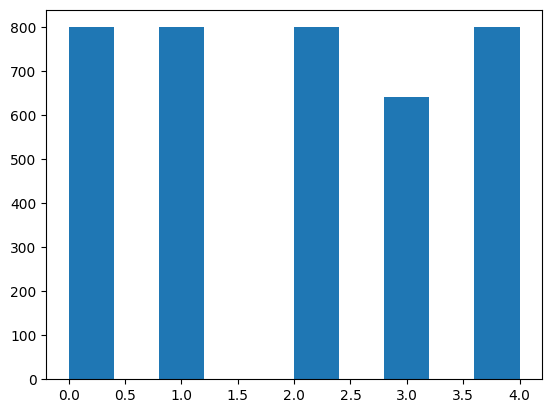

In [ ]:
plt.hist(Y)

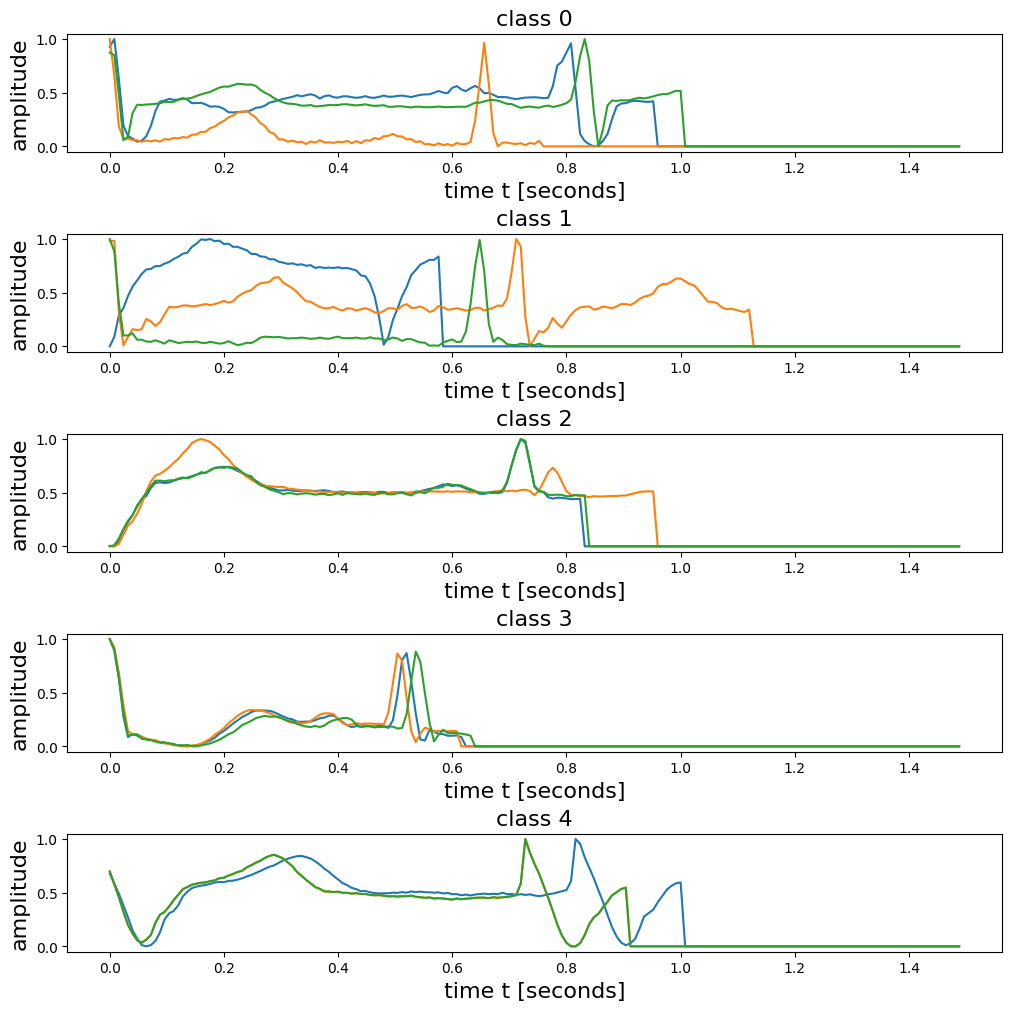

In [ ]:
fs=125  # sampling frequency
Ts=1/fs # sampling interval
N=187 # the number of timepoints
Duration=N*Ts # duration of a signal
t=np.linspace(0, Duration-Ts, N) # array of timepoints
fig, ax = plt.subplots(5,1,constrained_layout=True, figsize=(10,10))
for c in range(0, 5):
    for n in range(0, 3):
        idx=np.random.randint(0,10)
        ax[c].plot(t, X[Y==c][idx])
        ax[c].set_xlabel('time t [seconds]', fontsize=16)
        ax[c].set_ylabel('amplitude', fontsize=16)
    ax[c].set_title('class '+str(c), fontsize=16)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

In [ ]:
dataset_train=MyDataset(X_train, Y_train)
dataset_val=MyDataset(X_val, Y_val)
dataset_test=MyDataset(X_test, Y_test)

In [ ]:
loader_train = torch_dataloader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
loader_val = torch_dataloader(dataset_val, batch_size=128, shuffle=False, num_workers=0)
loader_test = torch_dataloader(dataset_test, batch_size=128, shuffle=False, num_workers=0)

## Create a model, and start the traning-validation-testing process

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=Net()
model.to(device)
x=dataset_train[0][0]
x=x.view(1,187).to(device) #change it to x=x.view(1,1,187).to(device) for CNN
z=model(x)

In [ ]:
y_hat=nnF.softmax(z, dim=1)
y_hat

tensor([[0.1669, 0.1704, 0.1566, 0.2787, 0.2274]], grad_fn=<SoftmaxBackward0>)

use stochastic gradient descent as the optimization method

In [ ]:
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
loss_train_list=[]
acc_train_list=[]
acc_val_list=[]
epoch_save=-1

train/val/test over many epochs

In [ ]:
for epoch in range(epoch_save+1, 100): #change 100 to a larger number if necessary
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    acc_val, other_val = test(model, device, loader_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation acc:', acc_val)
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list,
              acc_val_list, other_val)
    #change the name of the file if necessary
    save_checkpoint('ECG_MLP_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch

Train Epoch: 0 [0%]	Loss: 1.641248
epoch 0 training loss: 1.3049856315959583 acc: 0.4565846599131693
epoch 0 validation acc: 0.5064935
saved: ECG_MLP_Pytorch_epoch0.pt
Train Epoch: 1 [0%]	Loss: 1.182438
epoch 1 training loss: 1.089313723824241 acc: 0.6023878437047757
epoch 1 validation acc: 0.6233766
saved: ECG_MLP_Pytorch_epoch1.pt
Train Epoch: 2 [0%]	Loss: 0.988232
epoch 2 training loss: 0.9830127277157523 acc: 0.6780028943560058
epoch 2 validation acc: 0.6720779
saved: ECG_MLP_Pytorch_epoch2.pt
Train Epoch: 3 [0%]	Loss: 0.889022
epoch 3 training loss: 0.894049200144681 acc: 0.7301013024602026
epoch 3 validation acc: 0.73376626
saved: ECG_MLP_Pytorch_epoch3.pt
Train Epoch: 4 [0%]	Loss: 0.804988
epoch 4 training loss: 0.7966368306766857 acc: 0.7785817655571635
epoch 4 validation acc: 0.7532467
saved: ECG_MLP_Pytorch_epoch4.pt
Train Epoch: 5 [0%]	Loss: 0.737917
epoch 5 training loss: 0.7172756574370645 acc: 0.8035455861070911
epoch 5 validation acc: 0.77272725
saved: ECG_MLP_Pytorch_ep

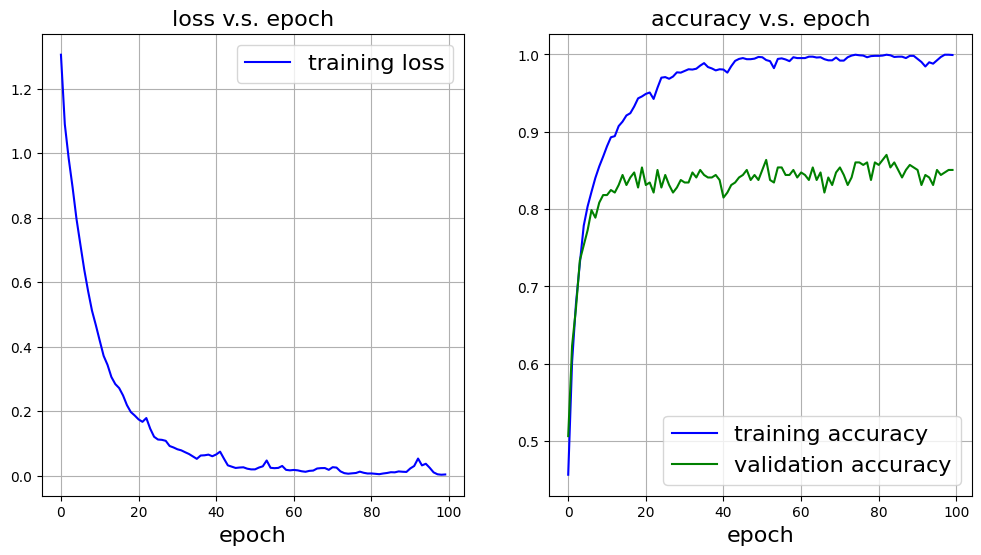

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('loss v.s. epoch',fontsize=16)
ax[0].plot(loss_train_list, '-b', label='training loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].set_title('accuracy v.s. epoch',fontsize=16)
ax[1].plot(acc_train_list, '-b', label='training accuracy')
ax[1].plot(acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

load the best model

In [ ]:
best_epoch=np.argmax(acc_val_list)
best_epoch

82

In [ ]:
checkpoint=torch.load('ECG_MLP_Pytorch_epoch'+str(best_epoch)+'.pt')
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device);
model.eval();

<ipython-input-85-7b68a2e167ca>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint=torch.load('ECG_MLP_Pytorch_epoch'+str(best_epoch)+'.pt')


In [ ]:
acc, (confusion, sens, prec) = test(model, device, loader_test)
print('Accuracy (average)', acc)
print('Sensitivity', sens)
print('Precision', prec)
print('Confusion \n', confusion)

Accuracy (average) 0.893368
Sensitivity [0.81818181 0.88961041 0.89041096 0.92622954 0.95321637]
Precision [0.82758623 0.8509317  0.91549295 0.90399998 0.97604793]
Confusion 
 [[144.  19.   6.   6.   1.]
 [ 14. 137.   3.   0.   0.]
 [  8.   0. 130.   5.   3.]
 [  7.   1.   1. 113.   0.]
 [  1.   4.   2.   1. 163.]]


Test Acc: 0.8934
